In [1]:
import math
import cv2
import munkres
import numpy as np
import io
import skimage.io as io
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib.image import imread

## 원본 이미지 그려보기

### 정답 가져오기
https://cocodataset.org/#download 에서 제공하는 2017 Train/Val annotations 를 사용

In [2]:
annFile = './person_keypoints_val2017.json'
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [3]:
catIds = coco_kps.getCatIds(catNms=['person'])
print("category ID ... ", catIds)

category ID ...  [1]


예제에 사용될 id 를 골라서 이미지를 그려본다.

In [4]:
imgIds = coco_kps.getImgIds(imgIds = [157928])
img = coco_kps.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

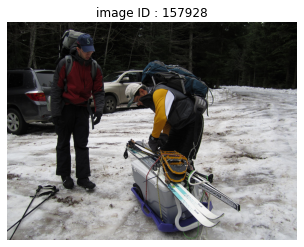

In [5]:
image = io.imread(img['coco_url'])
plt.axis('off')
plt.title('image ID : {}'.format(img['id']))
plt.imshow(image)
plt.show()

In [6]:
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
print(len(anns))

2


#### annotation 한 개 선택해서 bbox, keypoints 그려보기
v = 0 , not labled <br>
v = 1 , labeled but not visible <br>
v = 2 , labeled and visiable

In [18]:
gt_keypoint = anns[0]['keypoints']
gx = gt_keypoint[0::3]
gy = gt_keypoint[1::3]
print("X : {}\nY : {}\nV :{}".format(gx, gy, gt_keypoint[2::3]))

X : [181, 185, 172, 0, 157, 192, 128, 203, 107, 203, 108, 167, 130, 165, 124, 165, 127]
Y : [73, 64, 64, 0, 60, 102, 97, 152, 151, 197, 205, 202, 200, 271, 270, 341, 336]
V :[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [23]:
gt_area = anns[0]['area']
gt_bbox = anns[0]['bbox']
print('gt_bbox : {}\ngt_area: {}'.format(gt_bbox, gt_area))

gt_bbox : [94.05, 24.86, 122.17, 341.63]
gt_area: 26100.764


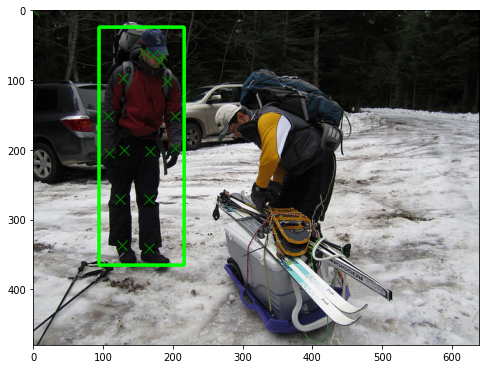

In [34]:
fig=plt.figure(figsize=(8,8))
image = io.imread(img['coco_url'])
cv2.rectangle(image, 
              (int(gt_bbox[0]), int(gt_bbox[1])),
              (int(gt_bbox[0])+int(gt_bbox[2]), int(gt_bbox[1])+int(gt_bbox[3])),
              (0,255,0), 4)
plt.plot(gx, gy, 'gx', markersize=10)
plt.imshow(image)
plt.show()

**bbox, keypoints을 모두 그려보기**

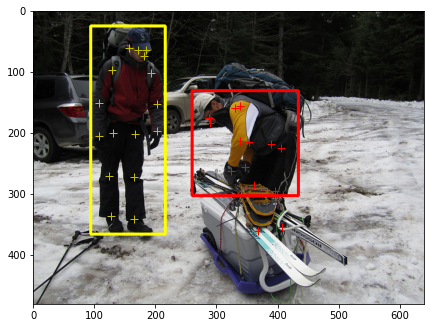

In [21]:
fig=plt.figure(figsize=(7,7))
image = io.imread(img['coco_url'])
colors = [(255,255,0), (255,0,0)]
colors2 = [ 'y+', 'r+']
for i, ann in enumerate(anns):
    cv2.rectangle(image, 
                  (int(ann['bbox'][0]), int(ann['bbox'][1])),
                  (int(ann['bbox'][0])+int(ann['bbox'][2]), int(ann['bbox'][1])+int(ann['bbox'][3])),
                  colors[i], 4)
    plt.plot(ann['keypoints'][0::3], ann['keypoints'][1::3], colors2[i], markersize=8)
plt.imshow(image)
plt.show()

### 추론 가져오기

In [11]:
pred_fn = './output_000000157928.json'
with open(pred_fn) as json_file:
    pred_anns = json.load(json_file)
pred_anns = pred_anns['0']

In [12]:
dt_keypoint =  np.array(pred_anns[1][0]).reshape(-1)
dt_bbox = pred_anns[0][0]
print('dt_keypoint : \n{}\ndt_bbox : {}'.format(dt_keypoint, dt_bbox))

dt_keypoint : 
[ 70.9375     182.25         0.95240134  63.75       185.83332825
   0.96880287  63.75       175.08332825   0.95050722  60.15625
 189.41667175   0.86673146  60.15625    157.16667175   0.95860016
 103.28125    193.           0.86545044  92.5        128.5
   0.87319428 153.59375    203.75         0.92613006 146.40625
 107.           0.86113089 196.71875    203.75         0.924519
 200.3125     107.           0.86786717 193.125      167.91667175
   0.86290503 189.53125    128.5          0.78688538 272.1875
 164.33332825   0.87512141 268.59375    124.91666412   0.87109667
 344.0625     167.91667175   0.88953817 336.875      128.5
   0.85396302]
dt_bbox : [21, 35, 279, 380]


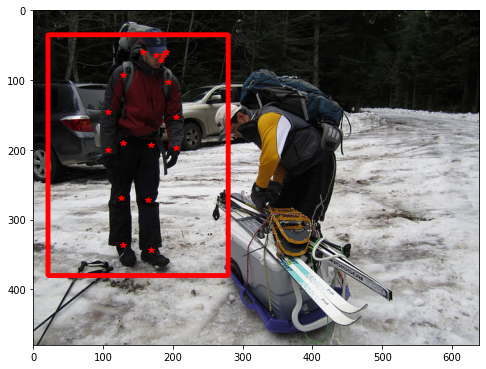

In [13]:
fig=plt.figure(figsize=(8,8))
image = io.imread(img['coco_url'])
cv2.rectangle(image, 
              (int(dt_bbox[0]), int(dt_bbox[1])),
              (int(dt_bbox[2]), int(dt_bbox[3])),
              (255,0,0), 5)
plt.plot(dt_keypoint[1::3], dt_keypoint[0::3], 'r*', markersize=6)
plt.imshow(image)
plt.show()

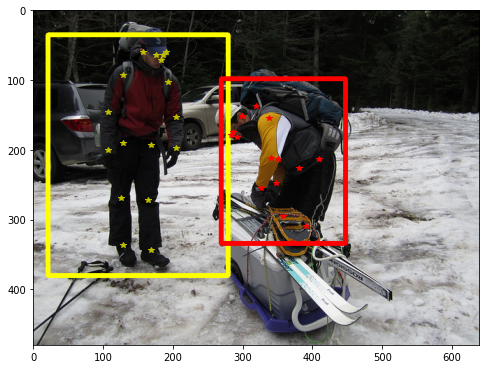

In [14]:
fig=plt.figure(figsize=(8,8))
image = io.imread(img['coco_url'])
colors = [(255,255,0), (255,0,0)]
colors3 = [ 'y*', 'r*']
for ann in pred_anns:
    for i, dt in enumerate(ann):
        if len(dt) == 4: # bbox
            cv2.rectangle(image, 
                          (int(dt[0]), int(dt[1])),
                          (int(dt[2]), int(dt[3])),
                          colors[i%2], 5)
        elif len(dt) == 17 : # keypoints
            dt = np.array(dt).reshape(-1)
            plt.plot(dt[1::3], dt[0::3], colors3[i%2], markersize=6)
plt.imshow(image)
plt.show()

## OKS 계산하기

$OKS = \Sigma_{i}{[exp(\frac{-d^2_i}{2s^2k^2_i}\delta(v_i > 0)]/\Sigma_{i}[\delta(v_{i}>0)]}$
- $d_i$ : Ground Truth keypoint 와 검출된 keypoint 사이의 Euclidean distance
- $v_i$ : Ground Truth 의 visibility flag ( 검출기의 예측된 $v_i$ 는 사용하지 X )
- $s$  : 객체 세그먼트 영역의 제곱근
- $k_i$ :  falloff 를 제어하는 keypoint 마다 존재하는 상수

레이블에 있는 모든 keypoint ( $v_i$ > 0 ) 에 대해 평균을 구한다. 

레이블링 되어있지 않는 예측 keypoint 는 OKS 에 영향을 미치지 않는다. 

ex ) 검출기가 왼쪽 손목의 keypoint 를 예측해서 결과가 나왔어도 왼쪽 손목이 레이블링 되어있지 않는다면 OKS 는 계산되지 않고 결과에 영향을 미치지 않는다. 

예측이 완벽하면 OKS = 1, 정답과 예측의 사이가 작을 수록 OKS 값이 1에 가까워진다.

객체 scale $s$ 에 대한 keypoint 당 표준편차 $\sigma_i$ 를 보면 $\sigma$ 값은 keypoint 에 따라 크게 달라진다.

어깨, 무릎, 엉덩이 등이 머리에 있는 눈,코,귀보다 훨씬 큰 $\sigma$를 갖는 경향이 있다.

In [15]:
kpt_oks_sigmas = np.array(
    [.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0
sigmas = kpt_oks_sigmas
vars = (sigmas * 2)**2
k = len(sigmas)

**한 명의 Annotation에 대한 OKS 구해보기**

In [16]:
dt_bbox1 = pred_anns [0][0]
dt_keypoint1 = pred_anns[1][0]

In [17]:
# create bounds for ignore regions(double the gt bbox)
g = np.array(anns[0]['keypoints'])
xg = g[0::3]; yg = g[1::3]; vg = g[2::3]
print("xg shape {} {}\nyg shape {} {}\nvg shape {} {}\n".format(
    xg.shape, xg, yg.shape,yg, vg.shape,vg))
k1 = np.count_nonzero(vg > 0)
bb = anns[0]['bbox']

x0 = bb[0] - bb[2]; x1 = bb[0] + bb[2] * 2
y0 = bb[1] - bb[3]; y1 = bb[1] + bb[3] * 2

d = np.array(dt_keypoint1).reshape(-1)
xd = d[1::3]; yd = d[0::3]
print("xd shape {} {}\nyd shape {} {}\n".format(
    xd.shape, xd, yd.shape, yd))

if k1>0:
    # measure the per-keypoint distance if keypoints visible
    dx = xd - xg
    dy = yd - yg
else:
    # measure minimum distance to keypoints in (x0,y0) & (x1,y1)
    z = np.zeros((k))
    dx = np.max((z, x0-xd),axis=0)+np.max((z, xd-x1),axis=0)
    dy = np.max((z, y0-yd),axis=0)+np.max((z, yd-y1),axis=0)

e = (dx**2 + dy**2) / vars / (anns[0]['area']+np.spacing(1)) / 2

if k1 > 0:
    e=e[vg > 0]
    
print('\ne >> ',e)

oks = np.sum(np.exp(-e)) / e.shape[0]
print('\nOKS >> ',oks)

xg shape (17,) [181 185 172   0 157 192 128 203 107 203 108 167 130 165 124 165 127]
yg shape (17,) [ 73  64  64   0  60 102  97 152 151 197 205 202 200 271 270 341 336]
vg shape (17,) [2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2]

xd shape (17,) [182.25       185.83332825 175.08332825 189.41667175 157.16667175
 193.         128.5        203.75       107.         203.75
 107.         167.91667175 128.5        164.33332825 124.91666412
 167.91667175 128.5       ]
yd shape (17,) [ 70.9375   63.75     63.75     60.15625  60.15625 103.28125  92.5
 153.59375 146.40625 196.71875 200.3125  193.125   189.53125 272.1875
 268.59375 344.0625  336.875  ]


e >>  [0.04120641 0.00580011 0.07332669 0.00020405 0.00202708 0.01573101
 0.00286622 0.01949515 0.00079935 0.02862099 0.03329926 0.0467848
 0.00117347 0.00178291 0.01081402 0.00182328]

OKS >>  0.9825084666744025


OKS 값은 1에 가까울 수록 정확한 예측이라고 판단한다.<br>
계산된 OKS가 0.98 로 예측 결과가 좋은 것을 확인할 수 있다.